# Prepare data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

def find_src_dir(start_path=None):
    """
    从 start_path 开始往上依次查找，直到根目录都没找到就报错。
    找到某层目录下有个 src 子文件夹就返回它的绝对路径。
    """
    if start_path is None:
        start_path = os.getcwd()
    path = start_path
    while True:
        candidate = os.path.join(path, "src")
        if os.path.isdir(candidate):
            return candidate
        parent = os.path.dirname(path)
        if parent == path:  # 已经到根目录了
            break
        path = parent
    raise FileNotFoundError(f"找不到 src 目录，已搜索到 {start_path} 的所有父级路径")

# 找到 src 并插入到 sys.path
try:
    SRC_PATH = find_src_dir()
    sys.path.insert(0, SRC_PATH)
    print("✅ 已将 src 添加到模块搜索路径：", SRC_PATH)
except FileNotFoundError as e:
    print("❌", e)

# 现在再试 import
from preprocess import *
#from tf_models import *
from torch_models import *

from pytorch_models import *

print("✅ import 成功！")

✅ 已将 src 添加到模块搜索路径： /Users/liujinxian/Desktop/NewNeworkForecast/ICC26/src
have tcn
✅ import 成功！


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker
base_dir = ".."

In [4]:
#file_name = f"{base_dir}/Processed_Dataset/CERNET_15min.csv"  # the input filename
file_name = f"{base_dir}/data/processed/CERNET.csv"  # the input filename
#file_name = f"{base_dir}/Processed_Dataset/Abilene_15min.csv"  # the input filename

In [5]:
df = pd.read_csv(file_name)
df = df.set_index('date')
df = df.dropna()
df = df.loc['2004-05-01':]
print(np.isnan(df).any(), np.isnan(df).any())

data    False
dtype: bool data    False
dtype: bool


In [6]:
df

,data
date,
2013-02-19 22:00:00,14961.012148
2013-02-19 23:00:00,12031.262185
2013-02-20 00:00:00,6400.142220
2013-02-20 01:00:00,3261.291051
2013-02-20 02:00:00,1978.597413
...,...
2013-03-26 11:00:00,31927.478640
2013-03-26 12:00:00,33363.036962
2013-03-26 13:00:00,34203.060161


# Temp Torch

## TCN earlyStopping

/Users/liujinxian/Desktop/NewNeworkForecast/ICC26/src/pytorch_models.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/torch/csrc/utils/tensor_new.cpp:281.)
  X = torch.tensor(X, dtype=torch.float32)


Epoch 1: Train Loss=0.8571, Val Loss=0.4902
Epoch 2: Train Loss=0.3177, Val Loss=0.1701
Epoch 3: Train Loss=0.1312, Val Loss=0.0688
Epoch 4: Train Loss=0.0633, Val Loss=0.0311
Epoch 5: Train Loss=0.0385, Val Loss=0.0219
Epoch 6: Train Loss=0.0320, Val Loss=0.0204
Epoch 7: Train Loss=0.0295, Val Loss=0.0194
Epoch 8: Train Loss=0.0282, Val Loss=0.0184
Epoch 9: Train Loss=0.0271, Val Loss=0.0177
Epoch 10: Train Loss=0.0262, Val Loss=0.0171
Epoch 11: Train Loss=0.0253, Val Loss=0.0166
Epoch 12: Train Loss=0.0244, Val Loss=0.0162
Epoch 13: Train Loss=0.0237, Val Loss=0.0158
Epoch 14: Train Loss=0.0230, Val Loss=0.0155
Epoch 15: Train Loss=0.0223, Val Loss=0.0152
Epoch 16: Train Loss=0.0218, Val Loss=0.0149
Epoch 17: Train Loss=0.0212, Val Loss=0.0147
Epoch 18: Train Loss=0.0207, Val Loss=0.0144
Epoch 19: Train Loss=0.0202, Val Loss=0.0142
Epoch 20: Train Loss=0.0198, Val Loss=0.0140
Epoch 21: Train Loss=0.0194, Val Loss=0.0139
Epoch 22: Train Loss=0.0190, Val Loss=0.0137
Epoch 23: Train Los

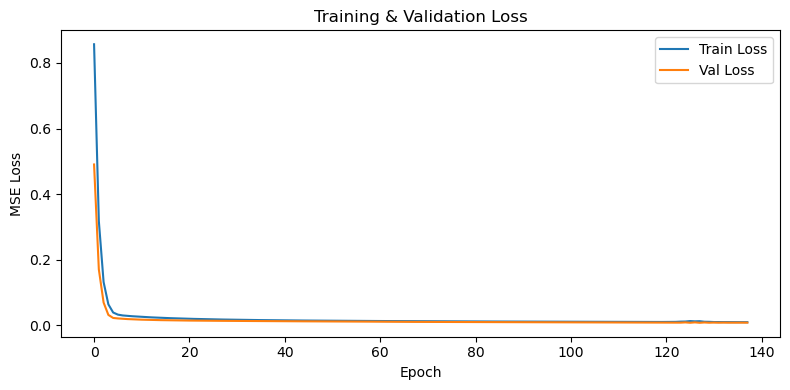

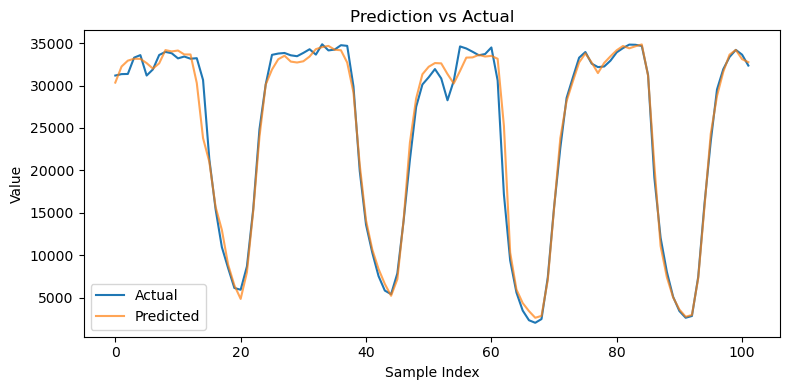

In [7]:
# 示範執行流程
values_raw = extract_values(df)
lag = 24
n_train, n_val, n_test = split_indices(len(values_raw), lag)
scaler = fit_scaler(values_raw, lag, n_train)
values = transform_values(values_raw, scaler)
X, y = create_sequences(values, lag)
train_loader, val_loader, test_loader = get_dataloaders(X, y, n_train, n_val)


#model = TCN(num_inputs=1, num_channels=[25,25], kernel_size=3, dropout=0.2)
model = FeedforwardNN(input_size=lag, hidden_size=50)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model, history = train_model(model, train_loader, val_loader, criterion, optimizer)
preds, acts = evaluate_model(model, test_loader, scaler)
metrics = compute_metrics(preds, acts)
print(metrics)

plot_loss(history)
plot_predictions(acts, preds)

## TimeMixer

Epoch 1: Train Loss=0.5938, Val Loss=0.2605
Epoch 2: Train Loss=0.1765, Val Loss=0.0832
Epoch 3: Train Loss=0.0714, Val Loss=0.0430
Epoch 4: Train Loss=0.0503, Val Loss=0.0354
Epoch 5: Train Loss=0.0411, Val Loss=0.0331
Epoch 6: Train Loss=0.0365, Val Loss=0.0306
Epoch 7: Train Loss=0.0340, Val Loss=0.0286
Epoch 8: Train Loss=0.0320, Val Loss=0.0269
Epoch 9: Train Loss=0.0303, Val Loss=0.0253
Epoch 10: Train Loss=0.0288, Val Loss=0.0240
Epoch 11: Train Loss=0.0275, Val Loss=0.0229
Epoch 12: Train Loss=0.0264, Val Loss=0.0219
Epoch 13: Train Loss=0.0254, Val Loss=0.0212
Epoch 14: Train Loss=0.0245, Val Loss=0.0205
Epoch 15: Train Loss=0.0237, Val Loss=0.0199
Epoch 16: Train Loss=0.0231, Val Loss=0.0193
Epoch 17: Train Loss=0.0225, Val Loss=0.0189
Epoch 18: Train Loss=0.0219, Val Loss=0.0185
Epoch 19: Train Loss=0.0214, Val Loss=0.0181
Epoch 20: Train Loss=0.0210, Val Loss=0.0178
Epoch 21: Train Loss=0.0205, Val Loss=0.0175
Epoch 22: Train Loss=0.0201, Val Loss=0.0172
Epoch 23: Train Los

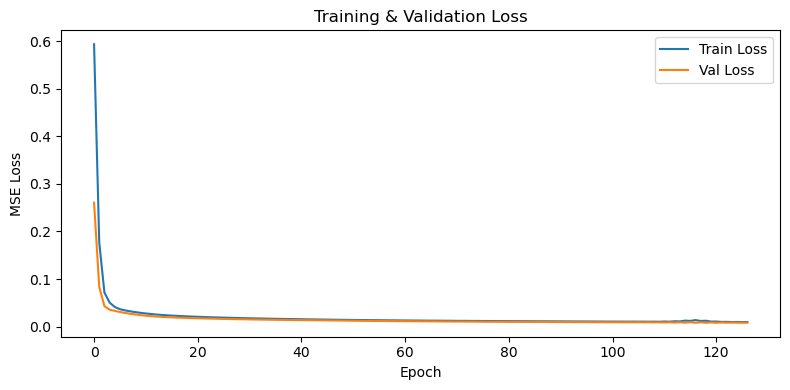

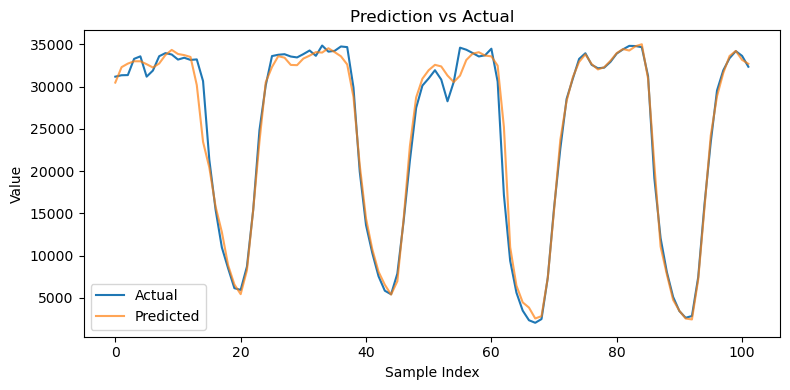

In [8]:
# 示範執行流程
values_raw = extract_values(df)
lag = 24
n_train, n_val, n_test = split_indices(len(values_raw), lag)
scaler = fit_scaler(values_raw, lag, n_train)
values = transform_values(values_raw, scaler)
X, y = create_sequences(values, lag)
train_loader, val_loader, test_loader = get_dataloaders(X, y, n_train, n_val)


#model = TCN(num_inputs=1, num_channels=[25,25], kernel_size=3, dropout=0.2)
model = FeedforwardNN(input_size=lag, hidden_size=50)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model, history = train_model(model, train_loader, val_loader, criterion, optimizer)
preds, acts = evaluate_model(model, test_loader, scaler)
metrics = compute_metrics(preds, acts)
print(metrics)

plot_loss(history)
plot_predictions(acts, preds)

### Save results.

In [42]:
import os
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# 定義一個函式，強制從 _1 開始依序編號檔名
def get_unique_filename(filename):
    """
    不論檔案是否存在，皆從 _1 開始附加到檔名上，
    若有同樣編號的檔案存在，則依序累加編號，直到找到尚不存在的檔名。
    """
    base, ext = os.path.splitext(filename)
    i = 1
    unique_filename = f"{base}_{i}{ext}"
    while os.path.exists(unique_filename):
        i += 1
        unique_filename = f"{base}_{i}{ext}"
    return unique_filename

# ------------------------
# 對測試集進行預測及計算指標
# ------------------------

# 進行測試集預測並轉換成一維陣列
predicted_test = model.predict(X_test).reshape(-1, 1)

# 計算各項回歸評估指標
mse = mean_squared_error(y_test, predicted_test)
mae = mean_absolute_error(y_test, predicted_test)
rmse = sqrt(mse)
r2 = r2_score(y_test, predicted_test)
mape = mean_absolute_percentage_error(y_test, predicted_test)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f'MAPE: {mape}')

# 將測試集真值與預測結果合併成 DataFrame
test_results = pd.DataFrame({
    'True': y_test.flatten(),
    'Predicted': predicted_test.flatten()
})

# 取得唯一檔名並儲存測試集結果成 CSV 檔案
test_csv_filename = get_unique_filename('test_predictions.csv')
test_results.to_csv(test_csv_filename, index=False)
print(f"測試集結果儲存到檔案: {test_csv_filename}")

# ------------------------
# 對訓練集進行預測並儲存結果
# ------------------------

# 預測訓練集資料
predicted_train = model.predict(X_train).reshape(-1, 1)

# 將訓練集真值與預測結果合併成 DataFrame
train_results = pd.DataFrame({
    'True': y_train.flatten(),
    'Predicted': predicted_train.flatten()
})

# 取得唯一檔名並儲存訓練集結果成 CSV 檔案
train_csv_filename = get_unique_filename('train_predictions.csv')
train_results.to_csv(train_csv_filename, index=False)
print(f"訓練集結果儲存到檔案: {train_csv_filename}")

AttributeError: 'TCN' object has no attribute 'predict'

# Informer

In [21]:
# === Colab Cell 1: （可选）清理旧仓库并 clone 官方代码 ===
import os
import shutil

if os.path.isdir('/content/Informer2020'):
    print("检测到旧的 Informer2020 目录，正在移除...")
    shutil.rmtree('/content/Informer2020')

!git clone https://github.com/zhouhaoyi/Informer2020.git


Cloning into 'Informer2020'...
remote: Enumerating objects: 579, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 579 (delta 0), reused 0 (delta 0), pack-reused 577 (from 2)
Receiving objects: 100% (579/579), 6.49 MiB | 10.48 MiB/s, done.
Resolving deltas: 100% (331/331), done.


In [22]:
import sys
# 将仓库根目录加入路径
sys.path.append('/content/Informer2020')

# 从官方实现中导入 Informer
from models.model import Informer as InformerModel

Epoch 001/200 — Train 641158756.131516 — Val 641377479.710843
Epoch 002/200 — Train 638641652.349639 — Val 638508816.308434
Epoch 003/200 — Train 635399354.919006 — Val 634898115.932530
Epoch 004/200 — Train 631408923.663192 — Val 630617484.183133
Epoch 005/200 — Train 626826364.458701 — Val 625757605.937349
Epoch 006/200 — Train 621606841.020048 — Val 620219434.640964
Epoch 007/200 — Train 615719869.972735 — Val 614081739.334940
Epoch 008/200 — Train 609232210.476343 — Val 607356762.563855
Epoch 009/200 — Train 602190556.484362 — Val 600074536.559036
Epoch 010/200 — Train 594578547.271852 — Val 592245209.792771
Epoch 011/200 — Train 586399647.101844 — Val 583899708.838554
Epoch 012/200 — Train 577722674.861267 — Val 575053225.253012
Epoch 013/200 — Train 568622829.061748 — Val 565728420.857831
Epoch 014/200 — Train 558944696.686448 — Val 555951610.178313
Epoch 015/200 — Train 548849672.827586 — Val 545728116.626506
Epoch 016/200 — Train 538271659.983961 — Val 535081126.168675
Epoch 01

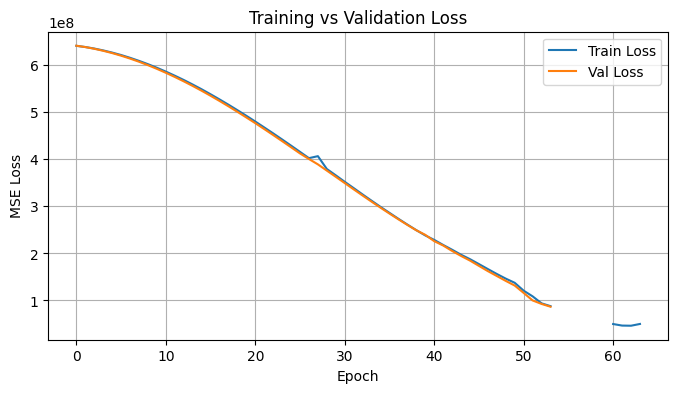

Test MSE: 96580790.139089


In [27]:
# === Colab Cell 1：导入依赖 ===
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt

from models.model import Informer as InformerModel  # 👈 forward 需 4 个输入：x_enc, x_mark_enc, x_dec, x_mark_dec

# 如果在 Notebook 里：
# %matplotlib inline


# === Colab Cell 2：准备数据 ===
# 假设你已在更早的 Cell 中定义好 NumPy 变量：
#   X_train, y_train, X_validation, y_validation, X_test, y_test
# 它们的形状分别为
#   X_*: (N, seq_len, input_dim)
#   y_*: (N,) 或者 (N,)

# 转 float32 并做成 Tensor
X_train      = torch.from_numpy(np.array(X_train,      dtype=np.float32))
y_train      = torch.from_numpy(np.array(y_train,      dtype=np.float32)).unsqueeze(-1)  # (N,1)
X_validation = torch.from_numpy(np.array(X_validation, dtype=np.float32))
y_validation = torch.from_numpy(np.array(y_validation, dtype=np.float32)).unsqueeze(-1)
X_test       = torch.from_numpy(np.array(X_test,       dtype=np.float32))
y_test       = torch.from_numpy(np.array(y_test,       dtype=np.float32)).unsqueeze(-1)

batch_size = 32
train_loader      = DataLoader(TensorDataset(X_train, y_train), batch_size, shuffle=True)
validation_loader = DataLoader(TensorDataset(X_validation, y_validation), batch_size)
test_loader       = DataLoader(TensorDataset(X_test, y_test), batch_size)


# === Colab Cell 3：定义模型 & 优化器 & 调度器 ===
input_dim  = X_train.shape[2]
output_dim = 1
seq_len    = 8
label_len  = seq_len
pred_len   = 1
d_feat     = 4

model = InformerModel(
    enc_in    = input_dim,
    dec_in    = input_dim,
    c_out     = output_dim,
    seq_len   = seq_len,
    label_len = label_len,
    out_len   = pred_len,
    factor    = 5,
    d_model   = 512,
    n_heads   = 8,
    e_layers  = 3,      # 增加 encoder 层数
    d_layers  = 2,      # 增加 decoder 层数
    d_ff      = 2048,
    dropout   = 0.1,
    attn      = 'prob',
    embed     = 'timeF',
    freq      = 'h'
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)


# === Colab Cell 4：训练 & 验证（含 EarlyStopping + Mixed Precision） ===
from torch.cuda.amp import autocast, GradScaler

num_epochs = 200
patience, wait = 20, 0
best_val_loss = float('inf')
scaler = GradScaler()

train_losses = []
val_losses   = []

eps = 1e-6

for epoch in range(1, num_epochs+1):
    # ——— 训练 ———
    model.train()
    total_train_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        # 全零时间特征（如需可替换为真实 time_features）
        x_mark_enc = torch.zeros(Xb.size(0), seq_len, d_feat, device=device)
        dec_in = torch.cat([
            Xb[:, -label_len:, :],
            torch.zeros(Xb.size(0), pred_len, input_dim, device=device)
        ], dim=1)
        x_mark_dec = torch.zeros(Xb.size(0), label_len+pred_len, d_feat, device=device)

        optimizer.zero_grad()
        with autocast():
            pred = model(Xb, x_mark_enc, dec_in, x_mark_dec).squeeze(-1)
            loss = criterion(pred, yb.squeeze(-1))
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item() * Xb.size(0)

    avg_train = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train)

    # ——— 验证 ———
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in validation_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            x_mark_enc = torch.zeros(Xb.size(0), seq_len, d_feat, device=device)
            dec_in = torch.cat([
                Xb[:, -label_len:, :],
                torch.zeros(Xb.size(0), pred_len, input_dim, device=device)
            ], dim=1)
            x_mark_dec = torch.zeros(Xb.size(0), label_len+pred_len, d_feat, device=device)

            pred = model(Xb, x_mark_enc, dec_in, x_mark_dec).squeeze(-1)
            total_val_loss += criterion(pred, yb.squeeze(-1)).item() * Xb.size(0)

    avg_val = total_val_loss / len(validation_loader.dataset)
    val_losses.append(avg_val)

    # ——— 调度 & EarlyStopping ———
    scheduler.step(avg_val)
    if avg_val + 1e-4 < best_val_loss:
        best_val_loss = avg_val
        wait = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f"EarlyStopping @ epoch {epoch}")
            break

    print(f"Epoch {epoch:03d}/{num_epochs} — Train {avg_train:.6f} — Val {avg_val:.6f}")


# === Colab Cell 5：画训练 & 验证 Loss 曲线 ===
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# === Colab Cell 6：测试集评估 & 预测 ===
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
total_test_loss = 0.0
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        x_mark_enc = torch.zeros(Xb.size(0), seq_len, d_feat, device=device)
        dec_in = torch.cat([
            Xb[:, -label_len:, :],
            torch.zeros(Xb.size(0), pred_len, input_dim, device=device)
        ], dim=1)
        x_mark_dec = torch.zeros(Xb.size(0), label_len+pred_len, d_feat, device=device)

        pred = model(Xb, x_mark_enc, dec_in, x_mark_dec).squeeze(-1)
        total_test_loss += criterion(pred, yb.squeeze(-1)).item() * Xb.size(0)

avg_test = total_test_loss / len(test_loader.dataset)
print(f"Test MSE: {avg_test:.6f}")

## PLOT

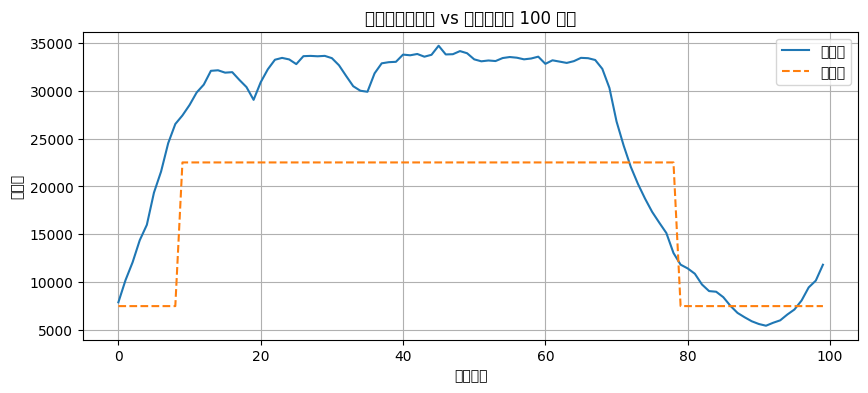

In [28]:
import matplotlib.pyplot as plt

# 1. 准备数据
# 将 y_test 转成 NumPy
y_true = y_test.cpu().numpy().squeeze()   # shape [N,]

# y_pred 已是 numpy，shape [N, pred_len]
# 如果 pred_len=1，就再 squeeze 成 [N,]
y_pred_1 = y_pred.squeeze()               # shape [N,]

# 2. 选择要画的点数
n_plot = min(100, len(y_true))  # 最多画 100 个点

# 3. 绘图
plt.figure(figsize=(10,4))
plt.plot(y_true[:n_plot], label='真實值')
plt.plot(y_pred_1[:n_plot], label='預測值', linestyle='--')
plt.xlabel('样本序号')
plt.ylabel('目标值')
plt.title('测试集：真實值 vs 預測值（前 {} 点）'.format(n_plot))
plt.legend()
plt.grid(True)
plt.show()

## ERROR

In [29]:
import torch

eps = 1e-6  # 防止除 0

# === Cell 6（或 Cell 5 中的验证段）替换成下面这段 ===
model.eval()
total_mse, total_mae, total_mape = 0.0, 0.0, 0.0
n_samples = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:  # 或 validation_loader
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # 构造 encoder/decoder 输入
        x_mark_enc = torch.zeros(X_batch.size(0), seq_len, d_feat, device=device)
        dec_in = torch.cat([
            X_batch[:, -label_len:, :],
            torch.zeros(X_batch.size(0), pred_len, input_dim, device=device)
        ], dim=1)
        x_mark_dec = torch.zeros(X_batch.size(0), label_len + pred_len, d_feat, device=device)

        # 前向
        pred = model(X_batch, x_mark_enc, dec_in, x_mark_dec).squeeze(-1)  # [B,]
        y_true = y_batch.squeeze(-1)                                     # [B,]

        # 各项指标
        mse   = torch.mean((pred - y_true) ** 2)
        mae   = torch.mean(torch.abs(pred - y_true))
        rmse  = torch.sqrt(mse)
        mape  = torch.mean(torch.abs((pred - y_true) / (y_true + eps))) * 100.0

        # 累加（按 batch 大小加权）
        bs = X_batch.size(0)
        total_mse  += mse.item()  * bs
        total_mae  += mae.item()  * bs
        total_mape += mape.item() * bs
        n_samples  += bs

# 计算全量平均
avg_mse  = total_mse  / n_samples
avg_rmse = avg_mse ** 0.5
avg_mae  = total_mae  / n_samples
avg_mape = total_mape / n_samples

print(f"Test MSE:  {avg_mse:.6f}")
print(f"Test RMSE: {avg_rmse:.6f}")
print(f"Test MAE:  {avg_mae:.6f}")
print(f"Test MAPE: {avg_mape:.2f}%")

Test MSE:  96580790.139089
Test RMSE: 9827.552602
Test MAE:  8866.915997
Test MAPE: 48.32%
